In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 64
BASE_DIR = "."
TRAINVAL_FILE = "trainval.txt"
EPOCHS = 50
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESIDUAL_THRESHOLD = 0.3 # Threshold for converting error map to binary mask

In [3]:
class DefectFreeDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()
            
        self.images = []

        for line in lines:
            img_path_rel, _ = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_temp.jpg"))
            img = Image.open(img_path_full).convert("RGB")
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            self.images.append(np.array(img, dtype=np.float32) / 255.0)

In [4]:
class DefectFreeDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()

        self.images = []

        for line in lines:
            img_path_rel, _ = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_temp.jpg"))
            img = Image.open(img_path_full).convert("RGB")
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            self.images.append(np.array(img, dtype=np.float32) / 255.0)
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32)
        return img, img

In [5]:
class DefectiveDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()
        
        self.images, self.masks = [], []

        for line in lines:
            img_path_rel, ann_path_rel = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_test.jpg"))
            ann_path_full = os.path.join(base_path, ann_path_rel)
            
            img = Image.open(img_path_full).convert("RGB")
            orig_size = img.size
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            self.images.append(np.array(img, dtype=np.float32) / 255.0)

            mask = np.zeros((img_size, img_size), dtype=np.int64)
            scale_x, scale_y = img_size / orig_size[0], img_size / orig_size[1]
            with open(ann_path_full, "r") as f_ann:
                for l in f_ann:
                    parts = l.strip().split()
                    if len(parts) < 5: continue
                    x1, y1, x2, y2, class_id = map(int, parts)
                    if class_id > 0:
                        nx1, ny1 = int(x1 * scale_x), int(y1 * scale_y)
                        nx2, ny2 = int(x2 * scale_x), int(y2 * scale_y)
                        mask[ny1:ny2, nx1:nx2] = 1 # Binary mask
            self.masks.append(mask)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.long)
        return img, mask

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            ResidualBlock(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ResidualBlock(256),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            ResidualBlock(32),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
def display_reconstruction(input_img, true_mask, reconstructed_img, residual_mask):
    plt.figure(figsize=(20, 5))


    plt.subplot(1, 4, 1)
    plt.imshow(input_img.permute(1, 2, 0).cpu().numpy())
    plt.title("Input Defective Image")


    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.cpu().numpy(), cmap='gray')
    plt.title("Ground Truth Mask")


    plt.subplot(1, 4, 3)
    plt.imshow(reconstructed_img.permute(1, 2, 0).cpu().numpy())
    plt.title("Reconstructed Image")


    plt.subplot(1, 4, 4)
    plt.imshow(residual_mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Predicted Residual Mask")


    plt.show()

Epoch [1/50], Reconstruction Loss: 0.157979


Epoch [2/50], Reconstruction Loss: 0.093724


Epoch [3/50], Reconstruction Loss: 0.080941


Epoch [4/50], Reconstruction Loss: 0.070577


Epoch [5/50], Reconstruction Loss: 0.058484


Epoch [6/50], Reconstruction Loss: 0.052572


Epoch [7/50], Reconstruction Loss: 0.047143


Epoch [8/50], Reconstruction Loss: 0.042704


Epoch [9/50], Reconstruction Loss: 0.040873


Epoch [10/50], Reconstruction Loss: 0.039550


Epoch [11/50], Reconstruction Loss: 0.036996


Epoch [12/50], Reconstruction Loss: 0.036077


Epoch [13/50], Reconstruction Loss: 0.034763


Epoch [14/50], Reconstruction Loss: 0.032617


Epoch [15/50], Reconstruction Loss: 0.032936


Epoch [16/50], Reconstruction Loss: 0.033748


Epoch [17/50], Reconstruction Loss: 0.031876


Epoch [18/50], Reconstruction Loss: 0.030900


Epoch [19/50], Reconstruction Loss: 0.031503


Epoch [20/50], Reconstruction Loss: 0.030408


Epoch [21/50], Reconstruction Loss: 0.027896


Epoch [22/50], Reconstruction Loss: 0.029632


Epoch [23/50], Reconstruction Loss: 0.029683


Epoch [24/50], Reconstruction Loss: 0.027396


Epoch [25/50], Reconstruction Loss: 0.025994


Epoch [26/50], Reconstruction Loss: 0.025157


Epoch [27/50], Reconstruction Loss: 0.025486


Epoch [28/50], Reconstruction Loss: 0.025711


Epoch [29/50], Reconstruction Loss: 0.024144


Epoch [30/50], Reconstruction Loss: 0.023457


Epoch [31/50], Reconstruction Loss: 0.022621


Epoch [32/50], Reconstruction Loss: 0.022362


Epoch [33/50], Reconstruction Loss: 0.022775


Epoch [34/50], Reconstruction Loss: 0.023369


Epoch [35/50], Reconstruction Loss: 0.021411


Epoch [36/50], Reconstruction Loss: 0.020664


Epoch [37/50], Reconstruction Loss: 0.020323


Epoch [38/50], Reconstruction Loss: 0.020182


Epoch [39/50], Reconstruction Loss: 0.020051


Epoch [40/50], Reconstruction Loss: 0.020730


Epoch [41/50], Reconstruction Loss: 0.019415


Epoch [42/50], Reconstruction Loss: 0.019703


Epoch [43/50], Reconstruction Loss: 0.019207


Epoch [44/50], Reconstruction Loss: 0.018916


Epoch [45/50], Reconstruction Loss: 0.019112


Epoch [46/50], Reconstruction Loss: 0.018496


Epoch [47/50], Reconstruction Loss: 0.017463


Epoch [48/50], Reconstruction Loss: 0.016750


Epoch [49/50], Reconstruction Loss: 0.016138


Epoch [50/50], Reconstruction Loss: 0.015937


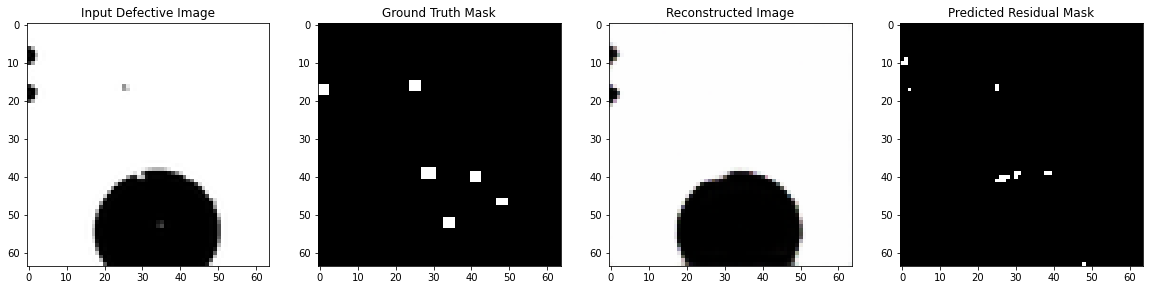

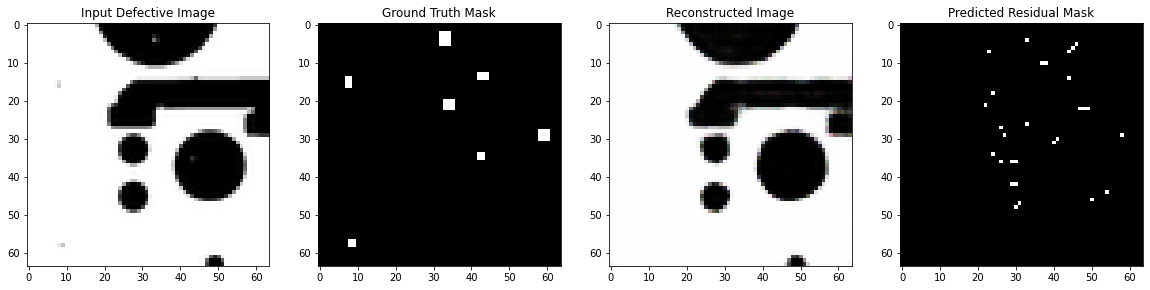

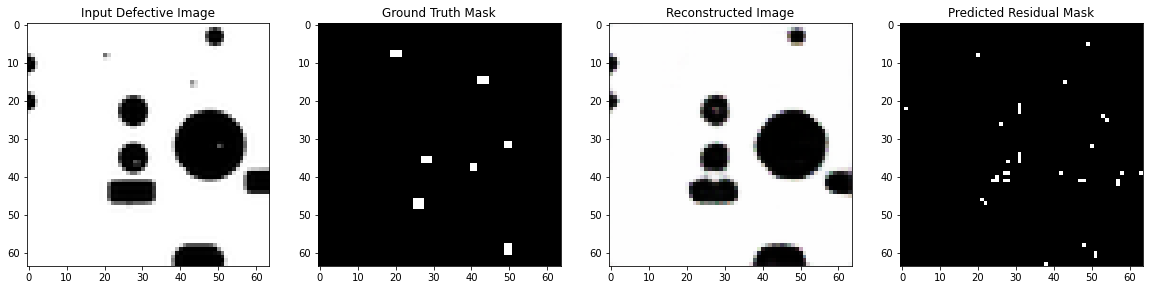

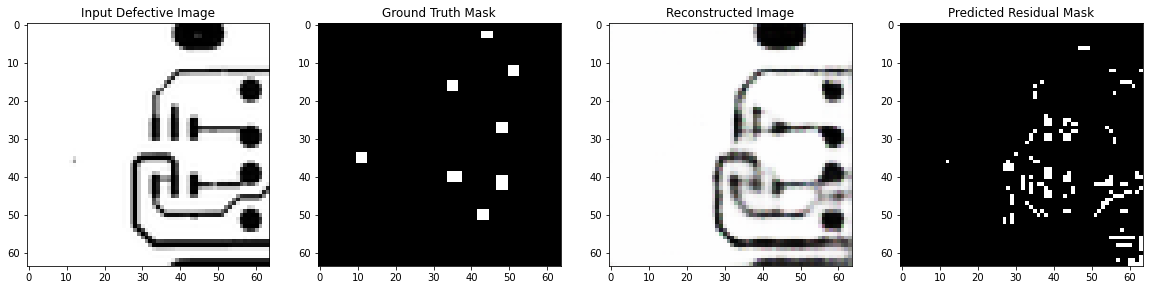

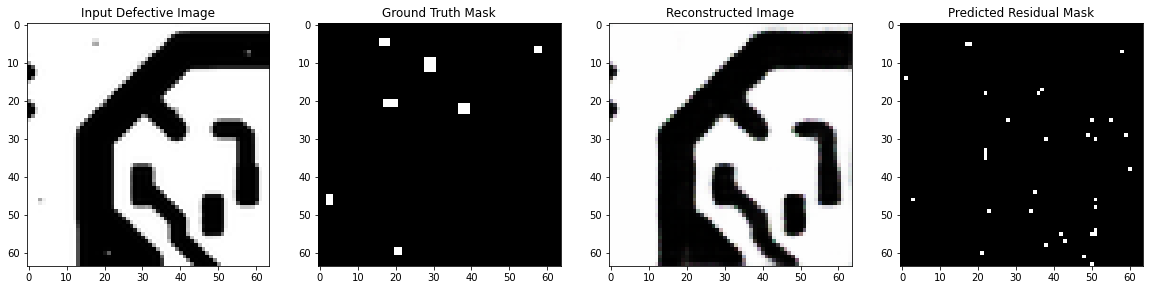

In [8]:
if __name__ == "__main__":
    free_dataset = DefectFreeDataset(BASE_DIR, TRAINVAL_FILE, IMG_SIZE)
    train_loader = DataLoader(free_dataset, batch_size=BATCH_SIZE, shuffle=True)


    model = Autoencoder().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()


    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)


        for imgs, targets in loop:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())


        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Reconstruction Loss: {epoch_loss:.6f}")


    defective_dataset = DefectiveDataset(BASE_DIR, TRAINVAL_FILE, IMG_SIZE)
    eval_loader = DataLoader(defective_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model.eval()
    with torch.no_grad():
        sample_imgs, sample_masks = next(iter(eval_loader))
        sample_imgs = sample_imgs.to(DEVICE)


        reconstructed_imgs = model(sample_imgs)
        
        residual_error = torch.abs(sample_imgs - reconstructed_imgs)
        residual_map_gray = torch.mean(residual_error, dim=1, keepdim=True)
        predicted_masks = (residual_map_gray > RESIDUAL_THRESHOLD).float()


        for i in range(min(5, len(sample_imgs))):
            display_reconstruction(
                sample_imgs[i],
                sample_masks[i],
                reconstructed_imgs[i],
                predicted_masks[i]
            )